# Liability-driven Investing
_The dominant method in modern investing_

Investing has two goals, delivering performance and protecting downside which can be schizophrenic goals. Instead of building a single portfolio to address both of these goals two portfolios are created:
* Performance-seeking portfolio (PSP)
    * Dedicated performance
    * Focus on diversified, efficient access to risk premia
* Liability-hedging portfolio (LHP)
    * Dedicated hedging
    * Focus on hedging impacts of risk factors in liabilities
    
Just as in options pricing, LDI has greeks:
* $\lambda_{psp}$ is the PSP Sharpe ratio: $\lambda=0 \Rightarrow$ no investment in PSP
* $\beta_{lhp}$ is the beta of liabilities with regard to LHP: $\beta=0 \Rightarrow$ no investment in LHP
* $\sigma_{psp}$ is the PSP volatility: $\sigma=\infty \Rightarrow$ no investment in PSP
* $\gamma$ is the risk-aversion_ $\gamma=\infty \Rightarrow$ no investment in PSP
    * It is difficult to identify how much and for whom (manager, beneificiary..)


_In the last notebook it was noted that it is difficult to find CZ bonds that match the given liabilities. In this notebook there will be a technique to get the advantage from a CZ bond through holding a portfolio of regular coupon-bearing bonds by doing factor/duration matching._

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from my_modules import risk
from my_modules import portfolio
from my_modules import model

import numpy as np
import pandas as pd

## GHP Construction with Duration Matching

In [5]:
def bond_cash_flows(maturity, principal=100, coupon_rate=0.03, coupons_pa=12):
    """
    Returns as series of cash flows from the bond, indexed by the coupon number
    """
    n_coupons = round(maturity*coupons_pa)
    coupon_amount = principal * coupon_rate/coupons_pa
    coupon_times = np.arange(1, n_coupons + 1)
    cash_flows = pd.Series(data=coupon_amount, index=coupon_times)
    cash_flows.iloc[-1] += principal #The final coupon payment will also return principal
    return cash_flows

In [8]:
def bond_price(maturity, principal=100, coupon_rate=0.03, coupons_pa=12, discount_rate=0.03):
    """
    Returns the price of a bond based on its maturity, coupon rate, and coupons per years as well as a 
    discount rate
    """
    cash_flows = bond_cash_flows(maturity, principal, coupon_rate, coupons_pa)
    return portfolio.pv(cash_flows, discount_rate/coupons_pa) #discount rate per period

In [6]:
bond_cash_flows(3, 100, 0.03, 2)

1      1.5
2      1.5
3      1.5
4      1.5
5      1.5
6    101.5
dtype: float64

In [10]:
bond_price(20, 1000, 0.05, 2, 0.04) #Is at a premium because the coupon is higher than the interest rate (discount)

1136.7773962036904

In [11]:
bond_price(20, 1000, 0.05, 2, 0.05)

1000.0000000000023

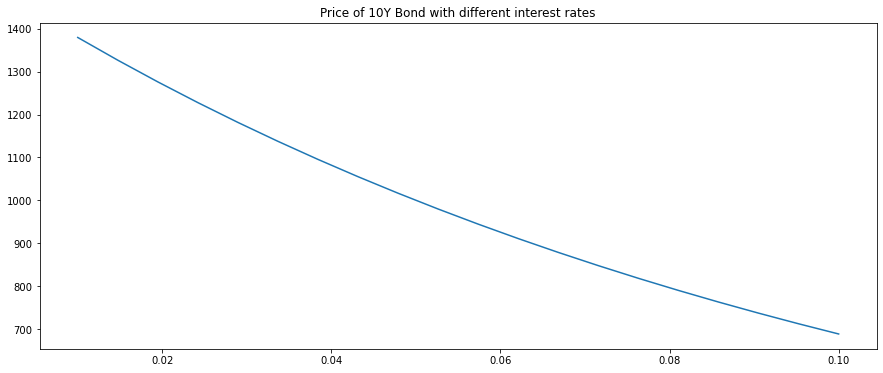

In [16]:
rates = np.linspace(0.01, .1, num=20)
prices = [bond_price(10,1000,0.05,2,rate) for rate in rates]
pd.DataFrame(data=prices, index=rates).plot(title="Price of 10Y Bond with different interest rates", legend=False, figsize=(15,6))

_Try to construct a portfolio of bonds that have a resiliance to interest rates_
* A ZC bond is simpler as the interest rates in the middle do not matter

In [17]:
cash_flows = bond_cash_flows(3, 1000, 0.06, 2)
cash_flows

1      30.0
2      30.0
3      30.0
4      30.0
5      30.0
6    1030.0
dtype: float64

In [18]:
# The present value of the coupons need to be taken
discounts = portfolio.discount(cash_flows.index, 0.06/2)

In [19]:
discounts # for the first 97%, for the final 84%

Float64Index([ 0.970873786407767, 0.9425959091337544, 0.9151416593531595,
              0.8884870479156888, 0.8626087843841639, 0.8374842566836542],
             dtype='float64')

In [20]:
discounted_cf = discounts * cash_flows
discounted_cf

1     29.126214
2     28.277877
3     27.454250
4     26.654611
5     25.878264
6    862.608784
dtype: float64

In [21]:
weights = discounted_cf/discounted_cf.sum()

In [22]:
weights

1    0.029126
2    0.028278
3    0.027454
4    0.026655
5    0.025878
6    0.862609
dtype: float64

In [25]:
# The bond maturation is in six years
# However, the average waiting duration, weighted by the present value of each of the cash flows 
# is equal to 5.57
# Macaulay Duration (https://www.investopedia.com/terms/m/macaulayduration.asp)
(cash_flows.index * weights).sum()

5.579707187194534

In [26]:
def macaulay_duration(cash_flows, discount_rate):
    """
    Computes the Macaulay Duration of the bond based on the cash flows and the discount rate
    """
    discounted_flows = portfolio.discount(cash_flows.index, discount_rate) * cash_flows
    weights = discounted_flows/discounted_flows.sum()
    return np.average(discounted_flows.index,weights=weights)

In [27]:
macaulay_duration(cash_flows, 0.06/2)

5.579707187194534

>_If you can match the Macaulay duration of your bonds to the Macaulay duration of the liability, what do you get? Then you get two portfolios that have the same sensitivity, they change in the same way with changes in interest rate. So this isn't literally, the Macaulay duration is not exactly equal to the first derivative of the change in price but it is directly related to it. They're connected and exactly the same way. Therefore, if you can match the duration of your liabilities and the duration of your bonds that you're holding, then you're home free. Because as interest rates move, your liabilities are going to go up but your bond portfolio is going to go up by hopefully the same amount._
* Not perfect, only works with vertical shifts in the entire yield curve

## Duration Matching

In [29]:
liabilities = pd.Series(data=[100_000, 100_000], index=[10,12])

In [32]:
macaulay_duration(liabilities, 0.04)

10.960799385088393

In an ideal world, would buy a ZC for 10.96 / or indivdual bonds with 10- and 12-year expiries
## Scenario
Keeping the siutation simple we have two bonds with a face value of 1000 and a 50 dollar annual coupon. We need to find out the ratio of the bonds we need to match the macualay duration of our liabilities

In [33]:
md_10 = macaulay_duration(bond_cash_flows(10, 1000, 0.05, 1), .04)
md_20 = macaulay_duration(bond_cash_flows(20, 1000, 0.05, 1), .04)
md_10, md_20

(8.190898824083233, 13.544718122145921)

$w_s =$  weight in the short duration bond

$d_s = $ the duration of duration of the short bond

$d_l = $ the duration of duration of the long bond

$d_t = $ targeted duration

In our case, the fraction in the short duration asset $w_s$ should be such that:

$$ w_s \times 8.19 + (1-w_s) \times 13.54 = 10.96 $$

more generally:

$$ w_s \times d_s + (1-w_s) \times d_l = d_t $$

rearranging gives:

$$ w_s = \frac{d_l -d_t}{d_l - d_s} $$

In [36]:
def match_durations(cashflows_target, cashflows_shortbond, cashflows_longbond, discount_rate):
    """
    Find the weight of the short bond so that, together with 1 - short bond weight, there will be an duration
    that matches the cashflows of the target
    """
    d_target = macaulay_duration(cashflows_target, discount_rate)
    d_short = macaulay_duration(cashflows_shortbond, discount_rate)
    d_long = macaulay_duration(cashflows_longbond, discount_rate)
    
    return (d_long - d_target) / (d_long - d_short)

In [37]:
short_bond = bond_cash_flows(10, 1000, 0.05, 1)
long_bond = bond_cash_flows(20, 1000, 0.05, 1)

w_short = match_durations(liabilities, short_bond, long_bond, 0.04)
w_short

0.48263092069478974

In [39]:
p_short = bond_price(10, 1000, .05, 1, .04)
p_long = bond_price(20, 1000, .05, 1, .04)
a_0 = 130_000
p_flows = pd.concat([a_0 * w_short * short_bond/p_short, a_0 * (1-w_short) * long_bond/p_long])

In [40]:
macaulay_duration(p_flows, 0.04) #We exactly meet the target

10.960799385088393

In [41]:
curr_funding_ratio = portfolio.funding_ratio(p_flows, liabilities, 0.04)
curr_funding_ratio

0.9998760012192478

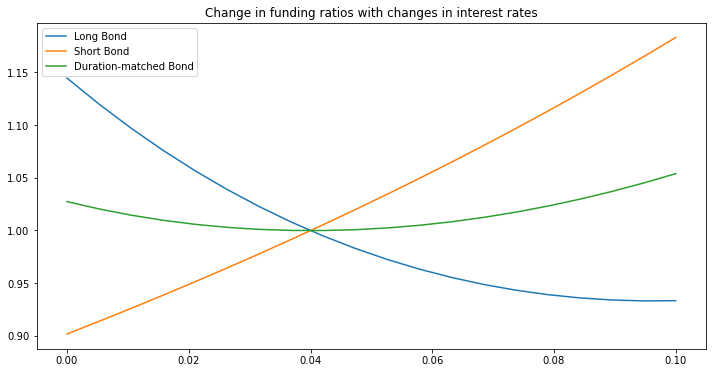

In [50]:
rates = np.linspace(0, .1, 20)
lb_assets = a_0 * long_bond/p_long
sb_assets = a_0 * short_bond/p_short

funding_ratio_change = pd.DataFrame({
    "Long Bond": [portfolio.funding_ratio(lb_assets, liabilities, r) for r in rates],
    "Short Bond": [portfolio.funding_ratio(sb_assets, liabilities, r) for r in rates],
    "Duration-matched Bond": [portfolio.funding_ratio(p_flows, liabilities, r) for r in rates]
}, index=rates)

funding_ratio_change.plot(title="Change in funding ratios with changes in interest rates", figsize=(12,6))
